<a href="https://colab.research.google.com/github/alpyesilgul/sunSpot_Prediction/blob/main/Time_Series_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Merhaba**, 1749 yılından 2018 yılına kadar Güneşimizde gözlenen [güneş lekeleri](https://tr.wikipedia.org/wiki/G%C3%BCne%C5%9F_lekeleri)nin bir kaydı ile gelecekte oluşabilecek lekeler için bir tahmin algoritması oluşturucağız

Basit bir algoritma olmasına karşın genel amacım elimden geldiğince Türkçe bir kaynak oluşturmak; zaman serileri ile tahmin algoritmalarının nasıl geliştirileceğine dair bir önsezi oluşturmak.

Gerekli açıklamalarda da bulunduğumuza göre biraz klavyeyi ısıtalım :)

In [1]:
# Datayı içeri aktaralım.
import pandas as pd
df = pd.read_csv('/content/Sunspots.csv')

In [2]:
# Dataya bi göz atalım
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


Datadan da görebildiğimiz gibi 1749'dan beri her ay olarak kayıt edilmiş şimdi gelin bu veriyi görselleştirelim.

In [11]:
series = df['Monthly Mean Total Sunspot Number'].values.astype(float)
time = df['Unnamed: 0'].values.astype(int)

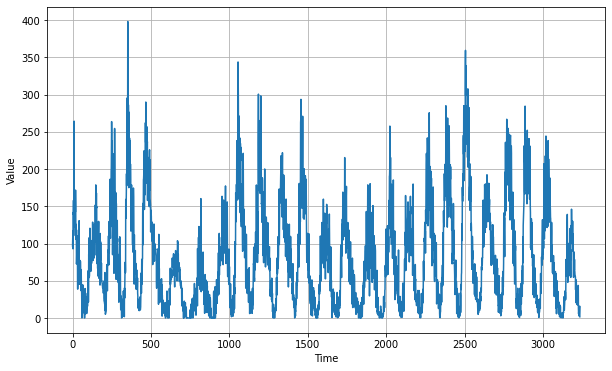

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

Şimdi görebiliceğimiz gibi bir zaman serisi grafiği var elimizde. Bu grafiği train ve validation olarak bölümlememiz gerekiyor.

In [13]:
# Toplamda 3214 zaman adımımız var 3000 train; 214 validation olarak bölümleyelim.
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Şimdi modele bir data pipeline oluşturmak gerekiyor. Pipeline veri işleyen bir sisteme veriyi en verimli şekilde kullanabilmesi için oluşturduğumuz bir dizi filtreleme işlemidir tabi kullanılma yerine göre tanımı farklı olabilir ama genel olarak anlamı bir filtreler dizisidir. Geleceğe yönelik bir tahmin yapıyoruz ve bunları geçmişe dayalı olarak ilerletiyoruz burda veriyi en verimli olarak örneğin 5'lik paketlerde(batch) birer adım ilerleyecek şekilde sisteme verebiliriz yani ağımız her aldığı veriyi ;
>[1,2,3,4], [2,3,4,5], [3,4,5,6] etc.

Bu batchlere karşılık da y değerleri yani doğru değerler olarak da bir sonraki değeri verebiliriz. Yani kısaca x,y haritalamamız şu şekilde olucak:

>{x:[1,2,3,4], y:[5], x:[2,3,4,5], y:[6] etc.}

"Bu bilgiler ışığında" -proje ödevlerinde kullanamayı en sevdiğim paragraf başı cümlesi ile- yardımcı fonksiyonumuzu oluşturalım

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # Model girdisi için bir eksen daha ekliyoruz.
    ds = tf.data.Dataset.from_tensor_slices(series) # Arrayı tensor objesine çeviririz.
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # Objeyi açıklamada olduğu gibi bölümleriz
    ds = ds.flat_map(lambda w: w.batch(window_size + 1)) # her bölümlemeyi paketleriz.
    ds = ds.shuffle(shuffle_buffer) # verim için veriyi karştırırz.
    ds = ds.map(lambda w: (w[:-1], w[1:])) # x,y haritalanmasını belirleriz.
    return ds.batch(batch_size).prefetch(1) #son olarak genel paketlenmeyi uygular,
    #bir sonraki veri için hazırlık oluştururuz.(bkz.tf.data.Dataset.prefetch)

Geleceğe dair tahminlere "forecast" denir. Eğitilen ağa test verisini gönderip tahminleri almak için de ayrı bir yardımcı fonksiyon oluşturalım.

In [15]:
def model_forecast(model, series, window_size):
    # Hepsi bildiğimiz işlemler...
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds) # Burda modelden tahminleri alıyoruz.
    return forecast

Geldik modeli oluşturmaya :) Şimdi veri setimizdeki x,y haritalanmasını anladık. İlk katman olarak 1 boyutta Conv ağı kullandık. Bilenler elbette ki vardır, konvülasyon görüntülerdeki dikey yatay çizgileri öğrenmek için kullandığımız bir katman. Teorik olarak bir matristeki patternları yakalıyor ve veri setimize baktığımızda bu patternları yakalamak oldukça işimize yarayabilir. Günlük hayatımızda gelecek için deterministik tahminler yürütmek için ilk başvurumuz geçmiş, yani tecrübelerimizdir. Bu bakış açısı ile de Long-Short Term Memory katmanı kullanmak oldukça makul :) Son katmanda ise en nihayetinde bu bir grafik, tahminleri daha duyarlı hale getirmek adına her sonucu 400 ile çarptım. Bir bakıma bu tahmin-zaman fonksiyon eğrisini 400 birim yukarı çektim gibi kabaca bir açıklama ile anlatılabilir. İsterseniz Lambda katmanını silerek tahminlere bakabilirsiniz.

In [17]:
import tensorflow as tf

In [18]:
shuffle_buffer_size = 1000 
window_size = 60 # Her bir veri seti 60'lık arraylerden oluşur.
batch_size = 100 # batch_size*steps_per_epoch = 3000 
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), # Loss func için bkz.Huber loss-Wikipedia
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 8s 144ms/step - loss: 58.2857 - mae: 58.7831
Epoch 2/500
30/30 [==============================] - 4s 142ms/step - loss: 26.0566 - mae: 26.5516
Epoch 3/500
30/30 [==============================] - 4s 126ms/step - loss: 22.3899 - mae: 22.8838
Epoch 4/500
30/30 [==============================] - 4s 145ms/step - loss: 21.0396 - mae: 21.5331
Epoch 5/500
30/30 [==============================] - 4s 144ms/step - loss: 20.1036 - mae: 20.5964
Epoch 6/500
30/30 [==============================] - 5s 144ms/step - loss: 18.8521 - mae: 19.3446
Epoch 7/500
30/30 [==============================] - 4s 141ms/step - loss: 18.8391 - mae: 19.3312
Epoch 8/500
30/30 [==============================] - 4s 134ms/step - loss: 18.7111 - mae: 19.2038
Epoch 9/500
30/30 [==============================] - 4s 131ms/step - loss: 18.7382 - mae: 19.2308
Epoch 10/500
30/30 [==============================] - 4s 134ms/step - loss: 17.9970 - mae: 18.4890
Epoch 11/500
30/30 

In [23]:
# Modeli eğittik şimdi sıra tahminde
import numpy as np
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [24]:
rnn_forecast

array([117.03279   ,  99.591194  , 107.57837   , 112.943665  ,
        96.01622   , 136.71461   , 190.76355   , 177.71541   ,
       155.90126   , 118.47778   , 105.87162   , 134.11829   ,
       138.33342   , 137.84651   , 173.14618   , 171.77818   ,
       170.3287    , 156.36496   , 152.44475   , 160.01497   ,
       154.03477   , 155.62846   , 159.03612   , 174.47617   ,
       171.80547   , 148.41672   , 147.66707   , 173.16086   ,
       158.97296   , 142.10486   , 169.91754   , 138.87375   ,
       147.70995   , 202.63571   , 180.25507   , 177.51614   ,
       179.81548   , 174.27911   , 153.11029   , 173.40024   ,
       190.73645   , 194.77258   , 172.21541   , 175.64125   ,
       196.79802   , 186.37013   , 173.09578   , 170.98915   ,
       148.70712   , 150.39215   , 115.994774  , 120.82497   ,
       106.47369   ,  92.086624  , 112.11849   , 101.16793   ,
        96.463715  ,  90.06619   ,  92.458725  ,  79.58705   ,
        66.12911   ,  67.974785  ,  75.59435   ,  80.90

Tüm veri için tahmin aldık ve test kısmını bölümledik. Elde edilen tahminlerin doğruluğunu gerçek değerlerle bir grafikte yazdıralım ve tartışalım.

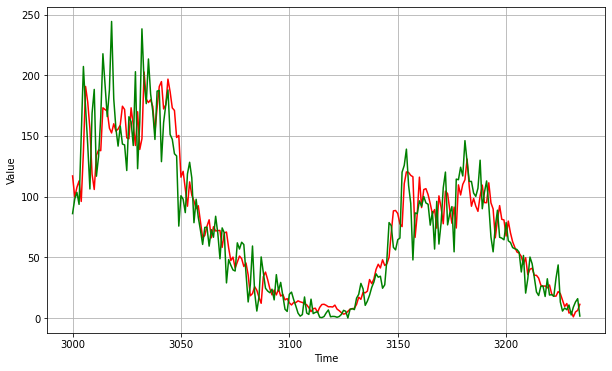

In [26]:
plt.figure(figsize=(10,6))
plt.plot(time_valid, rnn_forecast, 'r') #Kırmızı tahminlerimiz
plt.plot(time_valid, x_valid,'g') # Yeşil gerçek değerler
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

Sezgisel olarak algoritma gerçek zamanlı kullanılması hiç makul değil :) Ki güneş lekeleri gibi hassas bi konu için tartışalamaz bile. Fakat önsezi için oluşturduğumuz ağ fena denemeyecek tahminler ortaya koydu. Doğru optimizasyon ve veri analizi teknikleri ile daha spesifik tahminler de bulunabilicek ağlar üretmemiz mümkün hele ki elimizde bunun gibi oldukça fazla veri varsa :) Ne derler bilirsiniz "Let the data take care ".
Ben öğrendikçe buraya elimden geldiğince daha çok proje bırakıcam galiba bu benim için bir yeni hobi oldu popüler de olamıyacağım için istediğiniz zaman bana ulaşabilirsiniz :) Esen kalın <3